# Sweep Analysis Notebook

This notebook provides comprehensive analysis and visualization of hyperparameter sweep results from WandB.

## Features:
- Summary statistics of sweep parameters and metrics
- Cost vs Score scatter plot with level sets
- Time vs Score plot
- Time vs Cost plot
- Parameter correlation matrix
- Parameter importance analysis


In [82]:
# Settings Cell - Configure your sweep analysis here

# WandB Configuration
WANDB_ENTITY = "metta-research"  # Replace with your WandB entity
WANDB_PROJECT = "metta"  # Replace with your WandB project
# WANDB_SWEEP_NAME = "axel.sweep.advanced_arena_808.v1"  # Replace with your sweep name
WANDB_SWEEP_NAME = "axel.arena_phased_812.v1"  # Replace with your sweep name

# Analysis Configuration
MAX_OBSERVATIONS = 1000  # Maximum number of observations to load
TOP_K_PARAMETERS = 15  # Number of top parameters to show in importance plot
FIGURE_SIZE = (10, 8)  # Default figure size for plots
COLOR_PALETTE = "coolwarm"  # Color palette for visualizations


In [83]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from typing import Dict, List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Add the metta module to path if running from notebooks directory
sys.path.append(os.path.abspath('../..'))

# Import sweep utilities
from metta.sweep.wandb_utils import get_sweep_runs, deep_clean
import wandb

# Set seaborn style
sns.set_palette(COLOR_PALETTE)


In [84]:
# Helper functions for data processing

def flatten_nested_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '.') -> Dict[str, Any]:
    """Recursively flatten a nested dictionary structure."""
    items = []
    
    if not isinstance(d, dict):
        return {parent_key: d} if parent_key else {}
    
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            # Recursively flatten nested dictionaries
            items.extend(flatten_nested_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    
    return dict(items)

def extract_observations_to_dataframe(observations: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert protein observations to a pandas DataFrame with properly flattened hyperparameters."""
    
    all_rows = []
    
    for obs in observations:
        if obs.get('is_failure', False):
            continue
        
        row_data = {}
        
        # Get suggestion - should already be a dict thanks to deep_clean
        suggestion = obs.get('suggestion', {})
        
        # Flatten the suggestion dictionary to get all hyperparameters
        if isinstance(suggestion, dict) and suggestion:
            flattened = flatten_nested_dict(suggestion)
            row_data.update(flattened)
        
        # Add metrics directly
        row_data['score'] = obs.get('objective', np.nan)
        row_data['cost'] = obs.get('cost', np.nan)
        row_data['runtime'] = obs.get('cost', np.nan)
        row_data['timestamp'] = obs.get('timestamp', obs.get('created_at', np.nan))
        
        all_rows.append(row_data)
    
    # Create DataFrame from list of dictionaries
    df = pd.DataFrame(all_rows)
    
    # Convert timestamp to datetime
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df


In [85]:
# Load sweep data using get_sweep_runs from wandb_utils
print(f"Loading sweep data from WandB...")
print(f"Entity: {WANDB_ENTITY}")
print(f"Project: {WANDB_PROJECT}")
print(f"Sweep Name: {WANDB_SWEEP_NAME}")

# Use get_sweep_runs to fetch all runs from the sweep
from metta.sweep.wandb_utils import get_sweep_runs

runs = get_sweep_runs(
    sweep_name=WANDB_SWEEP_NAME,
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT
)

print(f"\nLoaded {len(runs)} runs")

# Extract observations and metadata from runs
observations = []
run_metadata = []

for run in runs[:MAX_OBSERVATIONS]:  # Limit to MAX_OBSERVATIONS
    # Get protein observation if it exists
    protein_obs = run.summary.get("protein_observation")
    
    # Also check for protein_suggestion if observation doesn't have suggestion
    protein_suggestion = run.summary.get("protein_suggestion")
    
    if protein_obs:
        # Use deep_clean to properly convert WandB objects to regular Python dicts
        obs = deep_clean(protein_obs)
        
        # If observation doesn't have suggestion but we have protein_suggestion, add it
        if 'suggestion' not in obs and protein_suggestion:
            obs['suggestion'] = deep_clean(protein_suggestion)
            
        obs['timestamp'] = run.created_at
        obs['run_name'] = run.name
        obs['run_id'] = run.id
        observations.append(obs)
    elif protein_suggestion:
        # If we only have protein_suggestion, create an observation from it
        obs = {
            'suggestion': deep_clean(protein_suggestion),
            'objective': run.summary.get('score', run.summary.get('protein.objective', np.nan)),
            'cost': run.summary.get('_wandb', {}).get('runtime', 0),
            'is_failure': run.state != 'finished',
            'timestamp': run.created_at,
            'run_name': run.name,
            'run_id': run.id
        }
        observations.append(obs)
        
    # Collect run metadata for cost analysis (all runs, not just with protein obs)
    metadata = {
        'run_id': run.id,
        'run_name': run.name,
        'timestamp': run.created_at,
        'runtime_seconds': run.summary.get('_wandb', {}).get('runtime', 0),
        'state': run.state,
        'score': run.summary.get('score', run.summary.get('protein.objective', 0))
    }
    
print(f"Valid observations with protein data: {len(observations)}")

# Convert observations to DataFrame
df = extract_observations_to_dataframe(observations)
print(f"Valid observations after filtering: {len(df)}")

# Create run metadata DataFrame for cost analysis
metadata_df = pd.DataFrame(run_metadata)
if not metadata_df.empty and 'timestamp' in metadata_df.columns:
    metadata_df['timestamp'] = pd.to_datetime(metadata_df['timestamp'])
    metadata_df = metadata_df.sort_values('timestamp').reset_index(drop=True)

# Show what parameters we found
param_cols = [col for col in df.columns if col not in ['score', 'cost', 'runtime', 'timestamp', 'run_name', 'run_id']]
print(f"\nFound {len(param_cols)} hyperparameters:")
if param_cols:
    for i, col in enumerate(param_cols[:10]):
        print(f"  - {col}")
    if len(param_cols) > 10:
        print(f"  ... and {len(param_cols) - 10} more")

# Show cost summary
if not metadata_df.empty and 'dollar_cost' in metadata_df.columns:
    total_cost = metadata_df['dollar_cost'].sum()
    print(f"\n💰 Total sweep cost: ${total_cost:.2f}")
    print(f"💵 Average cost per run: ${metadata_df['dollar_cost'].mean():.2f}")
    print(f"📊 Number of runs: {len(metadata_df)}")

Loading sweep data from WandB...
Entity: metta-research
Project: metta
Sweep Name: axel.arena_phased_812.v1

Loaded 177 runs
Valid observations with protein data: 177
Valid observations after filtering: 177

Found 15 hyperparameters:
  - trainer.batch_size
  - trainer.bptt_horizon
  - trainer.minibatch_size
  - trainer.optimizer.beta1
  - trainer.optimizer.beta2
  - trainer.optimizer.eps
  - trainer.optimizer.learning_rate
  - trainer.ppo.clip_coef
  - trainer.ppo.ent_coef
  - trainer.ppo.gae_lambda
  ... and 5 more


In [86]:
# Diagnostic: Check what columns we have in the DataFrame
print("DataFrame shape:", df.shape)
print("\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")
    
print("\nFirst few rows of data:")
df.head()


DataFrame shape: (177, 19)

Column names:
  1. trainer.batch_size
  2. trainer.bptt_horizon
  3. trainer.minibatch_size
  4. trainer.optimizer.beta1
  5. trainer.optimizer.beta2
  6. trainer.optimizer.eps
  7. trainer.optimizer.learning_rate
  8. trainer.ppo.clip_coef
  9. trainer.ppo.ent_coef
  10. trainer.ppo.gae_lambda
  11. trainer.ppo.gamma
  12. trainer.ppo.vf_clip_coef
  13. trainer.ppo.vf_coef
  14. trainer.total_timesteps
  15. trainer.update_epochs
  16. score
  17. cost
  18. runtime
  19. timestamp

First few rows of data:


,trainer.batch_size,trainer.bptt_horizon,trainer.minibatch_size,trainer.optimizer.beta1,trainer.optimizer.beta2,trainer.optimizer.eps,trainer.optimizer.learning_rate,trainer.ppo.clip_coef,trainer.ppo.ent_coef,trainer.ppo.gae_lambda,trainer.ppo.gamma,trainer.ppo.vf_clip_coef,trainer.ppo.vf_coef,trainer.total_timesteps,trainer.update_epochs,score,cost,runtime,timestamp
0,131072,16,4096,0.900000,0.9990,1.000000e-08,0.000300,0.200000,0.001000,0.950000,0.98000,10.000000,0.500000,250000000,2,0.008333,1005.268648,1005.268648,2025-08-12 23:48:04+00:00
1,131072,16,4096,0.900000,0.9990,1.000000e-08,0.000300,0.200000,0.001000,0.950000,0.98000,10.000000,0.500000,250000000,2,0.033333,1002.084962,1002.084962,2025-08-12 23:48:13+00:00
2,131072,16,4096,0.900000,0.9990,1.000000e-08,0.000300,0.200000,0.001000,0.950000,0.98000,10.000000,0.500000,250000000,2,0.050000,1008.352895,1008.352895,2025-08-12 23:48:20+00:00
3,131072,16,4096,0.900000,0.9990,1.000000e-08,0.000300,0.200000,0.001000,0.950000,0.98000,10.000000,0.500000,250000000,2,0.033333,1005.738055,1005.738055,2025-08-12 23:48:30+00:00
4,131072,16,4096,0.905103,0.9999,1.386986e-09,0.000324,0.189078,0.000765,0.960213,0.97813,21.359738,0.676298,259762701,3,0.016667,1298.472109,1298.472109,2025-08-13 00:08:47+00:00


In [87]:
# Show a sample observation to understand the structure
if observations:
    print("Sample observation structure:")
    import json
    print(json.dumps(observations[0], indent=2, default=str))


Sample observation structure:
{
  "cost": 5885.119097709656,
  "is_failure": false,
  "objective": 0.425,
  "suggestion": {
    "trainer": {
      "batch_size": 262144,
      "bptt_horizon": 16,
      "minibatch_size": 8192,
      "optimizer": {
        "beta1": 0.93,
        "beta2": 0.9995,
        "eps": 5.00000000000001e-08,
        "learning_rate": 0.0001000000000000002
      },
      "ppo": {
        "clip_coef": 0.1,
        "ent_coef": 0.0016638851288436705,
        "gae_lambda": 0.9110635527861988,
        "gamma": 0.9865228237432252,
        "vf_clip_coef": 25,
        "vf_coef": 0.75
      },
      "total_timesteps": 1500000000,
      "update_epochs": 2
    }
  },
  "timestamp": "2025-08-13T13:49:42Z",
  "run_name": "axel.arena_phased_812.v1.r.188",
  "run_id": "axel.arena_phased_812.v1.r.188"
}


## 1. Sweep Summary Statistics


In [88]:
# Calculate summary statistics
if not df.empty:
    # Identify parameter columns (exclude metrics)
    metric_cols = ['score', 'cost', 'time']
    param_cols = [col for col in df.columns if col not in metric_cols]
    
    # Get unique parameter values
    param_summary = {}
    for col in param_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            param_summary[col] = {
                'type': 'numeric',
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': df[col].std(),
                'unique_values': df[col].nunique()
            }
        else:
            param_summary[col] = {
                'type': 'categorical',
                'unique_values': df[col].nunique(),
                'values': df[col].unique().tolist()[:10]  # Show first 10 unique values
            }
    
    # Display sweep summary
    print("=" * 80)
    print("SWEEP SUMMARY")
    print("=" * 80)
    
    print(f"\nTotal Runs: {len(df)}")
    print(f"Successful Runs: {len(df[df['score'].notna()])}")
    print(f"Failed Runs: {len(observations) - len(df)}")
    
    print(f"\nMetrics Summary:")
    print(f"  Average Score: {df['score'].mean():.4f} (±{df['score'].std():.4f})")
    print(f"  Best Score: {df['score'].max():.4f}")
    print(f"  Worst Score: {df['score'].min():.4f}")
    
    print(f"\n  Average Run Time: {df['runtime'].mean():.2f} seconds")
    print(f"  Total Run Time: {df['runtime'].sum():.2f} seconds ({df['runtime'].sum()/3600:.2f} hours)")
    
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        print(f"\n  First Run: {df['timestamp'].min()}")
        print(f"  Last Run: {df['timestamp'].max()}")
        print(f"  Sweep Duration: {df['timestamp'].max() - df['timestamp'].min()}")
    
    print(f"\n  Average Cost: {df['cost'].mean():.2f}")
    print(f"  Total Cost: {df['cost'].sum():.2f}")
    
    print(f"\nParameters Being Swept ({len(param_cols)} total):")
    for i, (param, info) in enumerate(param_summary.items()):
        if i < 100:  # Show first 100 parameters
            if info['type'] == 'numeric':
                print(f"  - {param}: {info['min']:.4f} to {info['max']:.4f} ({info['unique_values']} unique values)")
            else:
                print(f"  - {param}: {info['unique_values']} unique values")
    
    if len(param_cols) > 100:
        print(f"  ... and {len(param_cols) - 10} more parameters")
else:
    print("No valid observations found in the sweep data.")


SWEEP SUMMARY

Total Runs: 177
Successful Runs: 177
Failed Runs: 0

Metrics Summary:
  Average Score: 0.0646 (±0.0456)
  Best Score: 0.4250
  Worst Score: 0.0083

  Average Run Time: 1717.91 seconds
  Total Run Time: 304070.74 seconds (84.46 hours)

  First Run: 2025-08-12 23:48:04+00:00
  Last Run: 2025-08-13 15:31:06+00:00
  Sweep Duration: 0 days 15:43:02

  Average Cost: 1717.91
  Total Cost: 304070.74

Parameters Being Swept (17 total):
  - trainer.batch_size: 131072.0000 to 262144.0000 (2 unique values)
  - trainer.bptt_horizon: 16.0000 to 16.0000 (1 unique values)
  - trainer.minibatch_size: 4096.0000 to 8192.0000 (2 unique values)
  - trainer.optimizer.beta1: 0.8382 to 0.9496 (93 unique values)
  - trainer.optimizer.beta2: 0.9967 to 0.9999 (69 unique values)
  - trainer.optimizer.eps: 0.0000 to 0.0000 (67 unique values)
  - trainer.optimizer.learning_rate: 0.0001 to 0.0005 (19 unique values)
  - trainer.ppo.clip_coef: 0.0500 to 0.2000 (60 unique values)
  - trainer.ppo.ent_coef

## 2. Cost vs Score Scatter Plot with Level Sets


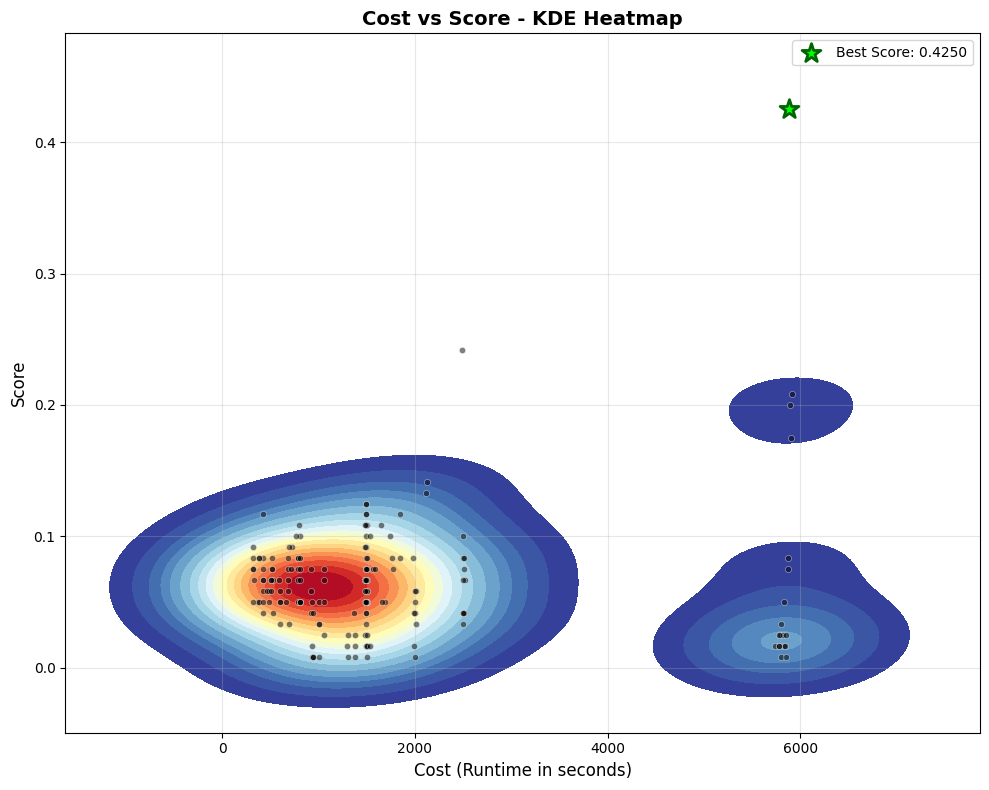

In [89]:
# Cost vs Score using Seaborn KDE (Kernel Density Estimation)
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        fig, ax = plt.subplots(figsize=FIGURE_SIZE)
        
        # KDE Heatmap
        try:
            # Create KDE plot with filled contours
            sns.kdeplot(
                data=plot_df,
                x='cost',
                y='score',
                fill=True,
                cmap='RdYlBu_r',
                levels=20,
                thresh=0.05,
                ax=ax
            )
            
            # Overlay scatter points
            ax.scatter(plot_df['cost'], plot_df['score'], 
                       alpha=0.5, s=20, c='black', edgecolors='white', 
                       linewidth=0.5, zorder=10)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax.scatter(plot_df.loc[best_idx, 'cost'], 
                       plot_df.loc[best_idx, 'score'],
                       color='lime', s=200, marker='*', 
                       edgecolors='darkgreen', linewidth=2,
                       label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f}',
                       zorder=20)
            
            ax.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Cost vs Score - KDE Heatmap', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"KDE plot failed: {e}")
            # Fallback to scatter plot if KDE fails
            ax.scatter(plot_df['cost'], plot_df['score'], 
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            ax.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title('Cost vs Score', fontsize=14, fontweight='bold')
            
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for density visualization")


## 2b. Advanced Cost vs Score Visualization

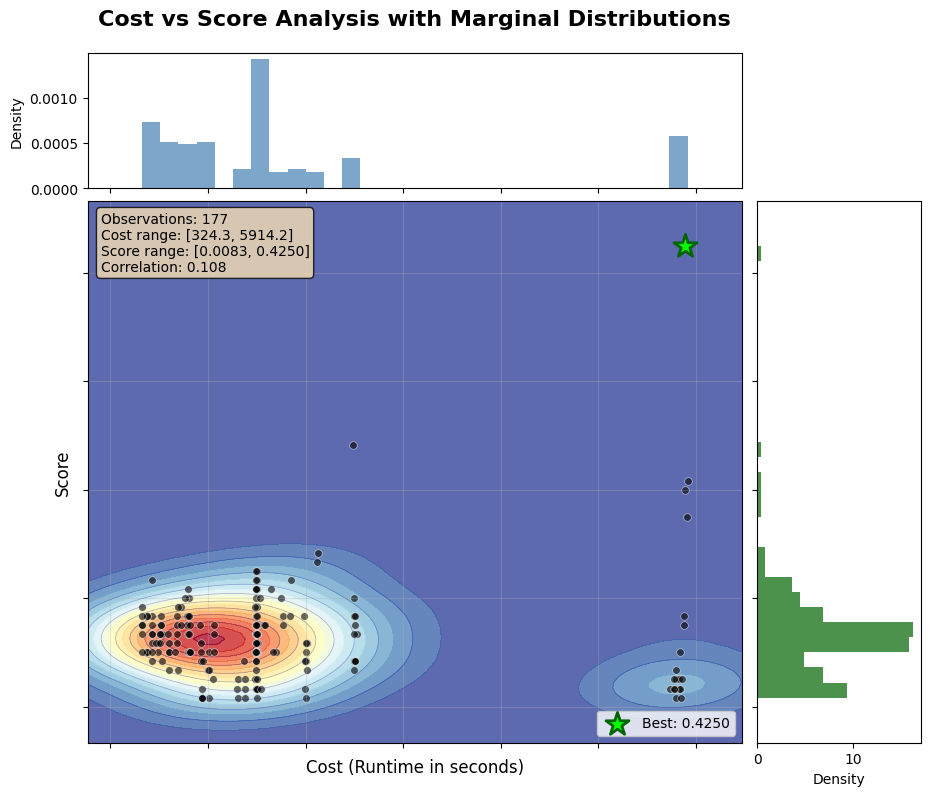

In [90]:
# Advanced visualization with marginal distributions
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        # Create figure with GridSpec for complex layout
        fig = plt.figure(figsize=(12, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05, 
                             height_ratios=[1, 4, 0.5], 
                             width_ratios=[4, 1, 0.5])
        
        # Main plot - 2D density heatmap
        ax_main = fig.add_subplot(gs[1, 0])
        
        # Top marginal - cost distribution
        ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
        
        # Right marginal - score distribution  
        ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
        
        # Main heatmap using gaussian KDE
        try:
            # Calculate 2D KDE
            from scipy.stats import gaussian_kde
            
            # Create grid for evaluation
            x_min, x_max = plot_df['cost'].min(), plot_df['cost'].max()
            y_min, y_max = plot_df['score'].min(), plot_df['score'].max()
            
            # Add padding
            x_range = x_max - x_min
            y_range = y_max - y_min
            x_min -= 0.1 * x_range
            x_max += 0.1 * x_range
            y_min -= 0.1 * y_range
            y_max += 0.1 * y_range
            
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([plot_df['cost'], plot_df['score']])
            kernel = gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)
            
            # Plot filled contours
            contourf = ax_main.contourf(xx, yy, f, levels=20, cmap='RdYlBu_r', alpha=0.8)
            
            # Add contour lines
            contour = ax_main.contour(xx, yy, f, levels=10, colors='darkblue', 
                                     alpha=0.3, linewidths=0.5)
            
            # Overlay actual data points
            scatter = ax_main.scatter(plot_df['cost'], plot_df['score'], 
                                     s=30, alpha=0.6, c='black', 
                                     edgecolors='white', linewidth=0.5)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax_main.scatter(plot_df.loc[best_idx, 'cost'], 
                           plot_df.loc[best_idx, 'score'],
                           color='lime', s=300, marker='*', 
                           edgecolors='darkgreen', linewidth=2,
                           label=f'Best: {plot_df.loc[best_idx, "score"]:.4f}',
                           zorder=100)
            
        except Exception as e:
            print(f"KDE calculation failed: {e}")
            # Fallback to simple scatter
            ax_main.scatter(plot_df['cost'], plot_df['score'], alpha=0.6)
        
        # Top marginal plot - cost distribution
        ax_top.hist(plot_df['cost'], bins=30, alpha=0.7, color='steelblue', density=True)
        ax_top.set_ylabel('Density')
        ax_top.set_xticklabels([])
        ax_top.set_title('Cost vs Score Analysis with Marginal Distributions', 
                        fontsize=16, fontweight='bold', pad=20)
        
        # Right marginal plot - score distribution
        ax_right.hist(plot_df['score'], bins=30, alpha=0.7, color='darkgreen', 
                     density=True, orientation='horizontal')
        ax_right.set_xlabel('Density')
        ax_right.set_yticklabels([])
        
        # Main plot labels
        ax_main.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
        ax_main.set_ylabel('Score', fontsize=12)
        ax_main.legend(loc='lower right')
        ax_main.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f"Observations: {len(plot_df)}\n"
        stats_text += f"Cost range: [{plot_df['cost'].min():.1f}, {plot_df['cost'].max():.1f}]\n"
        stats_text += f"Score range: [{plot_df['score'].min():.4f}, {plot_df['score'].max():.4f}]\n"
        stats_text += f"Correlation: {plot_df['cost'].corr(plot_df['score']):.3f}"
        
        ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    verticalalignment='top', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for advanced visualization")


## 3. Score Progression Over Time


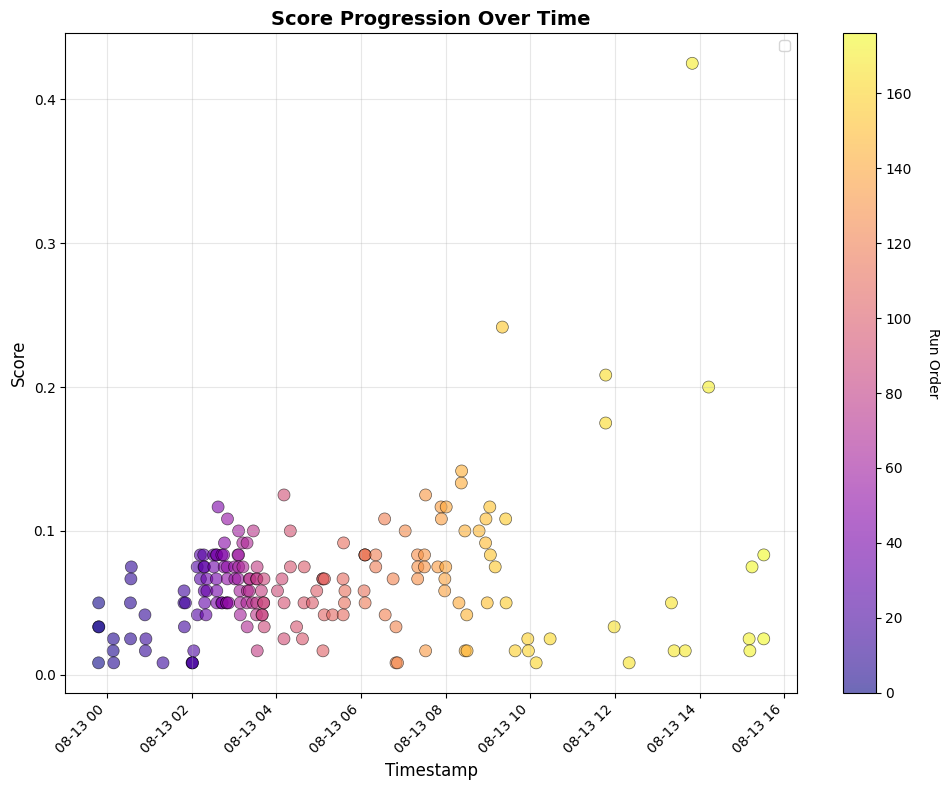

In [91]:
if not df.empty and 'timestamp' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'score']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing progression over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['score'], 
                           alpha=0.6, s=75, c=range(len(plot_df)), 
                           cmap='plasma', edgecolors='black', linewidth=0.5)
        
        # Add colorbar to show progression
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Score Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/score data to plot")
else:
    print("Missing timestamp or score data")


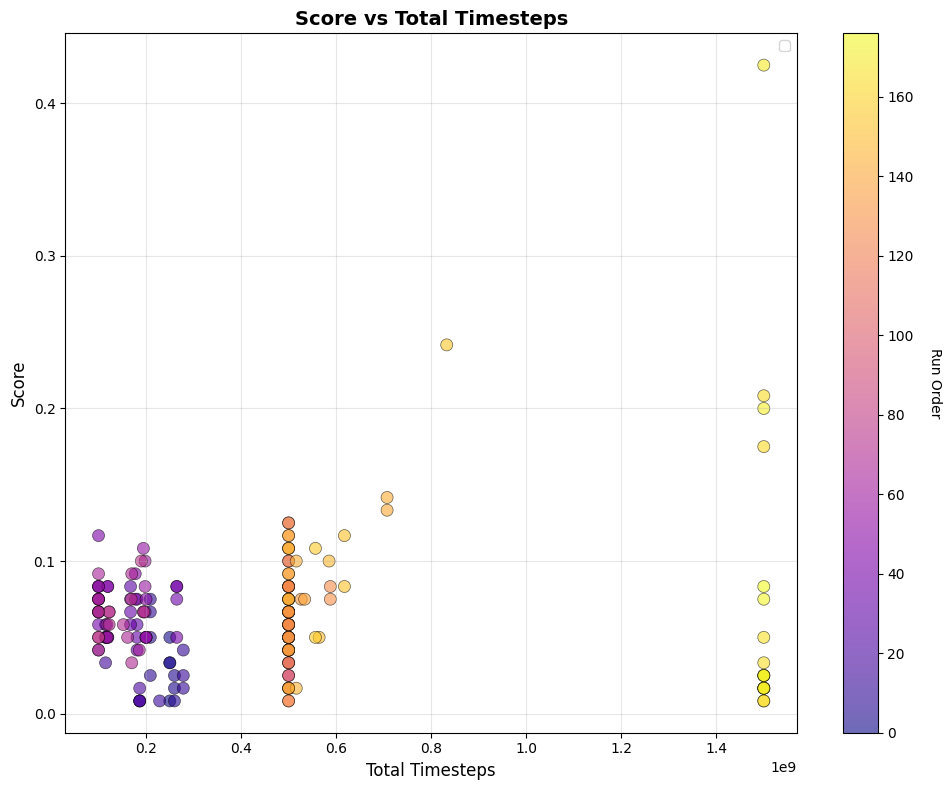

In [92]:
# 3b. Score vs Total Timesteps

if not df.empty and 'trainer.total_timesteps' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    # Remove NaNs
    plot_df = df[['trainer.total_timesteps', 'score', 'timestamp']].dropna()

    if len(plot_df) > 0:
        # Use run order for color, like the time plot
        if 'timestamp' in plot_df.columns:
            ts_vals = pd.to_datetime(plot_df['timestamp']).astype('int64').to_numpy()
            order = np.argsort(ts_vals)
        else:
            order = np.arange(len(plot_df))
        scatter = ax.scatter(plot_df['trainer.total_timesteps'], plot_df['score'],
                             alpha=0.6, s=75, c=order,
                             cmap='plasma', edgecolors='black', linewidth=0.5)

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)

        ax.set_xlabel('Total Timesteps', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Score vs Total Timesteps', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()

        # Log scale on x if timesteps span orders of magnitude
        try:
            if plot_df['trainer.total_timesteps'].max() / max(1, plot_df['trainer.total_timesteps'].min()) > 50:
                ax.set_xscale('log')
        except Exception:
            pass

        plt.tight_layout()
        plt.show()
    else:
        print('No valid timesteps/score data to plot')
else:
    print('Missing trainer.total_timesteps or score data')


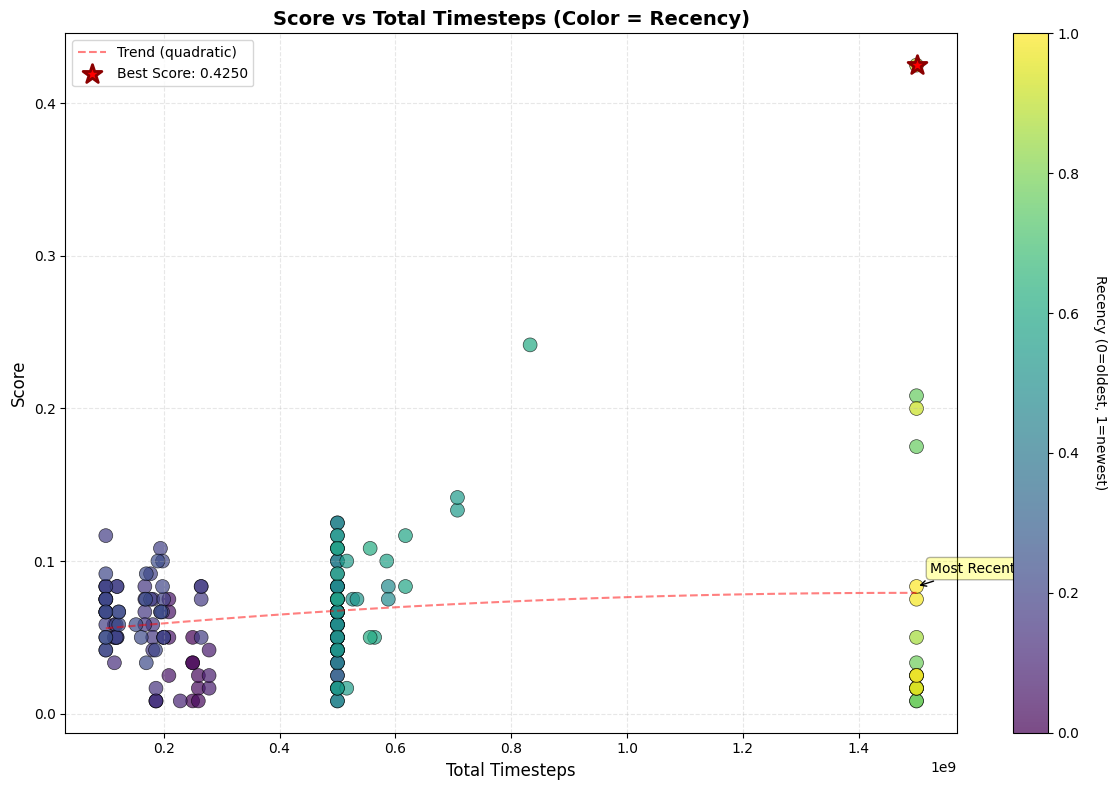


Timesteps range: 100000000 - 1500000000
Score range: 0.0083 - 0.4250
Correlation (timesteps vs score): 0.1454


In [93]:
# 3c. Enhanced Score vs Total Timesteps (with recency coloring)

if not df.empty and 'trainer.total_timesteps' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Remove NaNs and prepare data
    plot_df = df[['trainer.total_timesteps', 'score', 'timestamp']].dropna()
    
    if len(plot_df) > 0:
        # Calculate recency (0 = oldest, 1 = newest)
        if 'timestamp' in plot_df.columns:
            timestamps = pd.to_datetime(plot_df['timestamp'])
            min_time = timestamps.min()
            max_time = timestamps.max()
            if max_time > min_time:
                recency = (timestamps - min_time) / (max_time - min_time)
            else:
                recency = np.ones(len(plot_df))
        else:
            recency = np.linspace(0, 1, len(plot_df))
        
        # Create scatter plot with recency-based coloring
        scatter = ax.scatter(
            plot_df['trainer.total_timesteps'], 
            plot_df['score'],
            c=recency,
            cmap='viridis',  # Green (old) to Purple (new)
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Recency (0=oldest, 1=newest)', rotation=270, labelpad=20)
        
        # Add trend line if enough points
        if len(plot_df) > 10:
            z = np.polyfit(plot_df['trainer.total_timesteps'], plot_df['score'], 2)
            p = np.poly1d(z)
            x_trend = np.linspace(plot_df['trainer.total_timesteps'].min(), 
                                plot_df['trainer.total_timesteps'].max(), 100)
            ax.plot(x_trend, p(x_trend), 'r--', alpha=0.5, label='Trend (quadratic)')
        
        # Highlight best score
        best_idx = plot_df['score'].idxmax()
        best_row = plot_df.loc[best_idx]
        ax.scatter(best_row['trainer.total_timesteps'], best_row['score'], 
                  color='red', s=200, marker='*', edgecolors='darkred', 
                  linewidth=2, label=f'Best Score: {best_row["score"]:.4f}', zorder=5)
        
        # Set labels and title
        ax.set_xlabel('Total Timesteps', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Score vs Total Timesteps (Color = Recency)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')
        
        # Use log scale if timesteps span multiple orders of magnitude
        if plot_df['trainer.total_timesteps'].max() / plot_df['trainer.total_timesteps'].min() > 100:
            ax.set_xscale('log')
            ax.set_xlabel('Total Timesteps (log scale)', fontsize=12)
        
        # Add annotation for most recent run
        most_recent_idx = np.argmax(recency)
        most_recent = plot_df.iloc[int(most_recent_idx)]
        ax.annotate('Most Recent', 
                   xy=(most_recent['trainer.total_timesteps'], most_recent['score']),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nTimesteps range: {plot_df['trainer.total_timesteps'].min():.0f} - {plot_df['trainer.total_timesteps'].max():.0f}")
        print(f"Score range: {plot_df['score'].min():.4f} - {plot_df['score'].max():.4f}")
        print(f"Correlation (timesteps vs score): {plot_df['trainer.total_timesteps'].corr(plot_df['score']):.4f}")
    else:
        print("No valid timesteps/score data to plot")
else:
    print("Missing trainer.total_timesteps or score data")


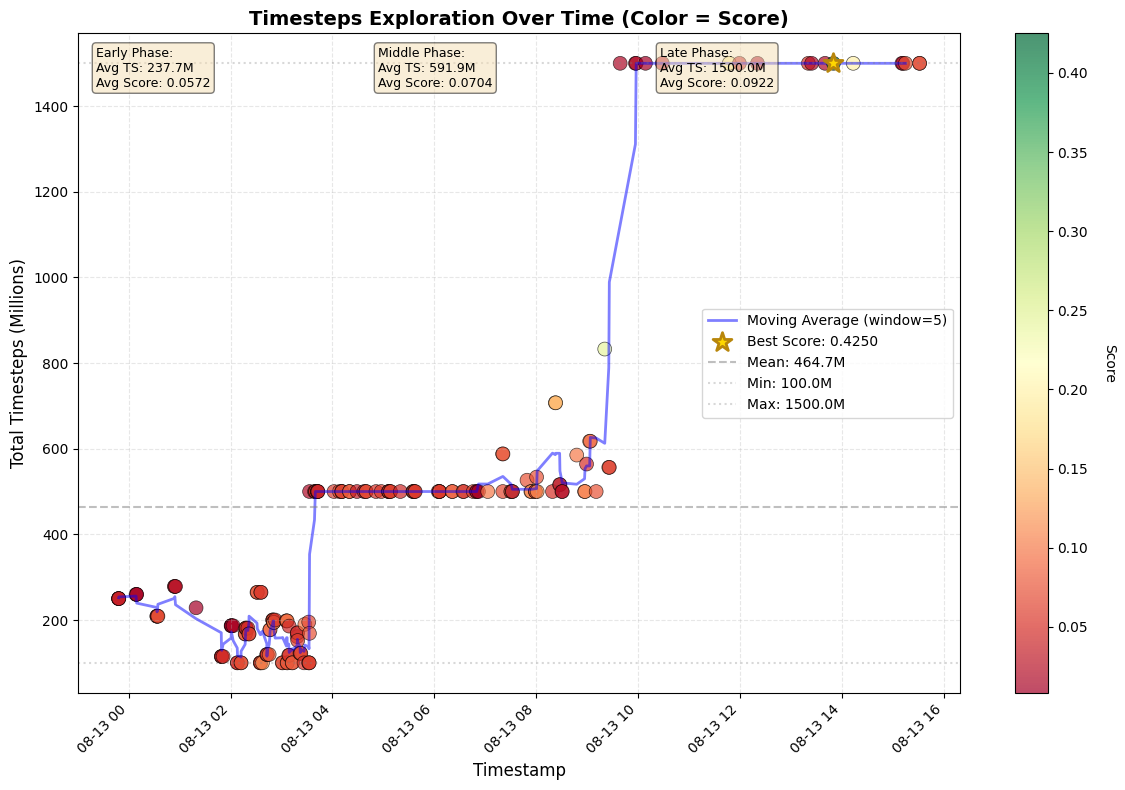


=== Timesteps Exploration Analysis ===
Total runs: 177
Timesteps range: 100.0M - 1500.0M
Timesteps std dev: 399.9M
Convergence: -285.5% reduction in variance (first vs second half)
Optimal timesteps range (top 10% scores): 100.0M - 1500.0M


In [94]:
# 5c. Timestamp vs Total Timesteps (Exploration over Time)

if not df.empty and 'trainer.total_timesteps' in df.columns and 'timestamp' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Remove NaNs and prepare data
    plot_df = df[['timestamp', 'trainer.total_timesteps', 'score']].dropna()
    
    if len(plot_df) > 0:
        # Convert timestamp to datetime if needed
        timestamps = pd.to_datetime(plot_df['timestamp'])
        
        # Convert timesteps to millions for display
        timesteps_millions = plot_df['trainer.total_timesteps'] / 1e6
        
        # Create scatter plot colored by score
        scatter = ax.scatter(
            timestamps, 
            timesteps_millions,
            c=plot_df['score'],
            cmap='RdYlGn',  # Red (low score) to Green (high score)
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Score', rotation=270, labelpad=20)
        
        # Add moving average line to show exploration trend
        if len(plot_df) > 5:
            # Sort by timestamp for rolling mean
            sorted_df = plot_df.sort_values('timestamp')
            sorted_timestamps = pd.to_datetime(sorted_df['timestamp'])
            
            # Calculate rolling mean with window of 5 runs (in millions)
            window_size = min(5, len(sorted_df) // 3)
            if window_size > 1:
                rolling_mean = sorted_df['trainer.total_timesteps'].rolling(window=window_size, center=True).mean() / 1e6
                ax.plot(sorted_timestamps, rolling_mean, 'b-', alpha=0.5, linewidth=2, 
                       label=f'Moving Average (window={window_size})')
        
        # Highlight best score run
        best_idx = plot_df['score'].idxmax()
        best_row = plot_df.loc[best_idx]
        best_timestamp = pd.to_datetime(best_row['timestamp'])
        ax.scatter(best_timestamp, best_row['trainer.total_timesteps'] / 1e6, 
                  color='gold', s=200, marker='*', edgecolors='darkgoldenrod', 
                  linewidth=2, label=f'Best Score: {best_row["score"]:.4f}', zorder=5)
        
        # Add horizontal lines for min, max, and mean timesteps (in millions)
        ax.axhline(y=timesteps_millions.mean(), color='gray', linestyle='--', 
                  alpha=0.5, label=f'Mean: {timesteps_millions.mean():.1f}M')
        ax.axhline(y=timesteps_millions.min(), color='gray', linestyle=':', 
                  alpha=0.3, label=f'Min: {timesteps_millions.min():.1f}M')
        ax.axhline(y=timesteps_millions.max(), color='gray', linestyle=':', 
                  alpha=0.3, label=f'Max: {timesteps_millions.max():.1f}M')
        
        # Set labels and title
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Total Timesteps (Millions)', fontsize=12)
        ax.set_title('Timesteps Exploration Over Time (Color = Score)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best', fontsize=10)
        
        # Use log scale for y-axis if timesteps span multiple orders of magnitude
        if timesteps_millions.max() / timesteps_millions.min() > 100:
            ax.set_yscale('log')
            ax.set_ylabel('Total Timesteps (Millions, log scale)', fontsize=12)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Add annotations for exploration phases
        # Divide timeline into thirds and analyze
        time_range = timestamps.max() - timestamps.min()
        third = time_range / 3
        
        for i, (start, end, label) in enumerate([
            (timestamps.min(), timestamps.min() + third, "Early"),
            (timestamps.min() + third, timestamps.min() + 2*third, "Middle"),
            (timestamps.min() + 2*third, timestamps.max(), "Late")
        ]):
            mask = (timestamps >= start) & (timestamps <= end)
            if mask.any():
                phase_data = plot_df[mask]
                avg_timesteps = phase_data['trainer.total_timesteps'].mean()
                avg_score = phase_data['score'].mean()
                
                # Add text annotation (convert to millions)
                ax.text(0.02 + i*0.32, 0.98, 
                       f'{label} Phase:\nAvg TS: {avg_timesteps/1e6:.1f}M\nAvg Score: {avg_score:.4f}',
                       transform=ax.transAxes, fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        # Print exploration statistics (in millions)
        print("\n=== Timesteps Exploration Analysis ===")
        print(f"Total runs: {len(plot_df)}")
        print(f"Timesteps range: {timesteps_millions.min():.1f}M - {timesteps_millions.max():.1f}M")
        print(f"Timesteps std dev: {timesteps_millions.std():.1f}M")
        
        # Calculate if exploration is converging
        first_half = plot_df.iloc[:len(plot_df)//2]['trainer.total_timesteps'].std() / 1e6
        second_half = plot_df.iloc[len(plot_df)//2:]['trainer.total_timesteps'].std() / 1e6
        convergence = (first_half - second_half) / first_half * 100 if first_half > 0 else 0
        print(f"Convergence: {convergence:.1f}% reduction in variance (first vs second half)")
        
        # Find optimal timesteps region
        top_10_percent = plot_df.nlargest(max(1, len(plot_df)//10), 'score')
        optimal_range = (top_10_percent['trainer.total_timesteps'].min() / 1e6, 
                        top_10_percent['trainer.total_timesteps'].max() / 1e6)
        print(f"Optimal timesteps range (top 10% scores): {optimal_range[0]:.1f}M - {optimal_range[1]:.1f}M")
        
    else:
        print("No valid timestamp/timesteps data to plot")
else:
    print("Missing timestamp or trainer.total_timesteps data")


## 4. Runtime Progression Over Time


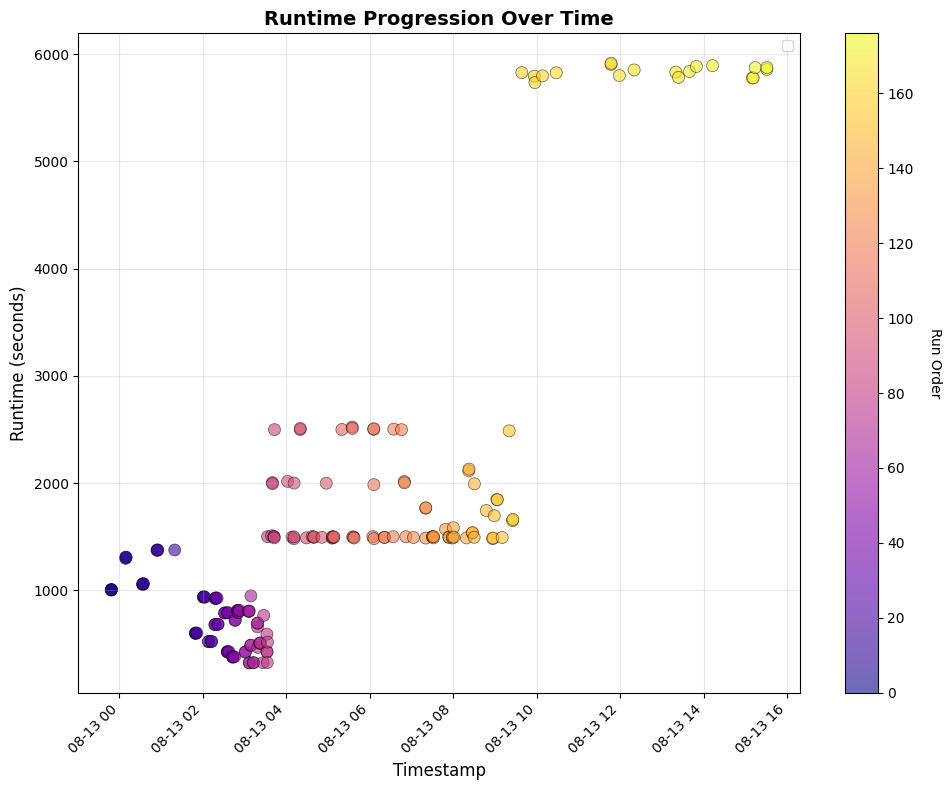

In [95]:
if not df.empty and 'timestamp' in df.columns and 'runtime' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'runtime']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing runtime over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['runtime'], 
                           alpha=0.6, s=75, c=range(len(plot_df)), 
                           cmap='plasma', edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Runtime (seconds)', fontsize=12)
        ax.set_title('Runtime Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/runtime data to plot")
else:
    print("Missing timestamp or runtime data")


## 5. Parameter Correlation Matrix

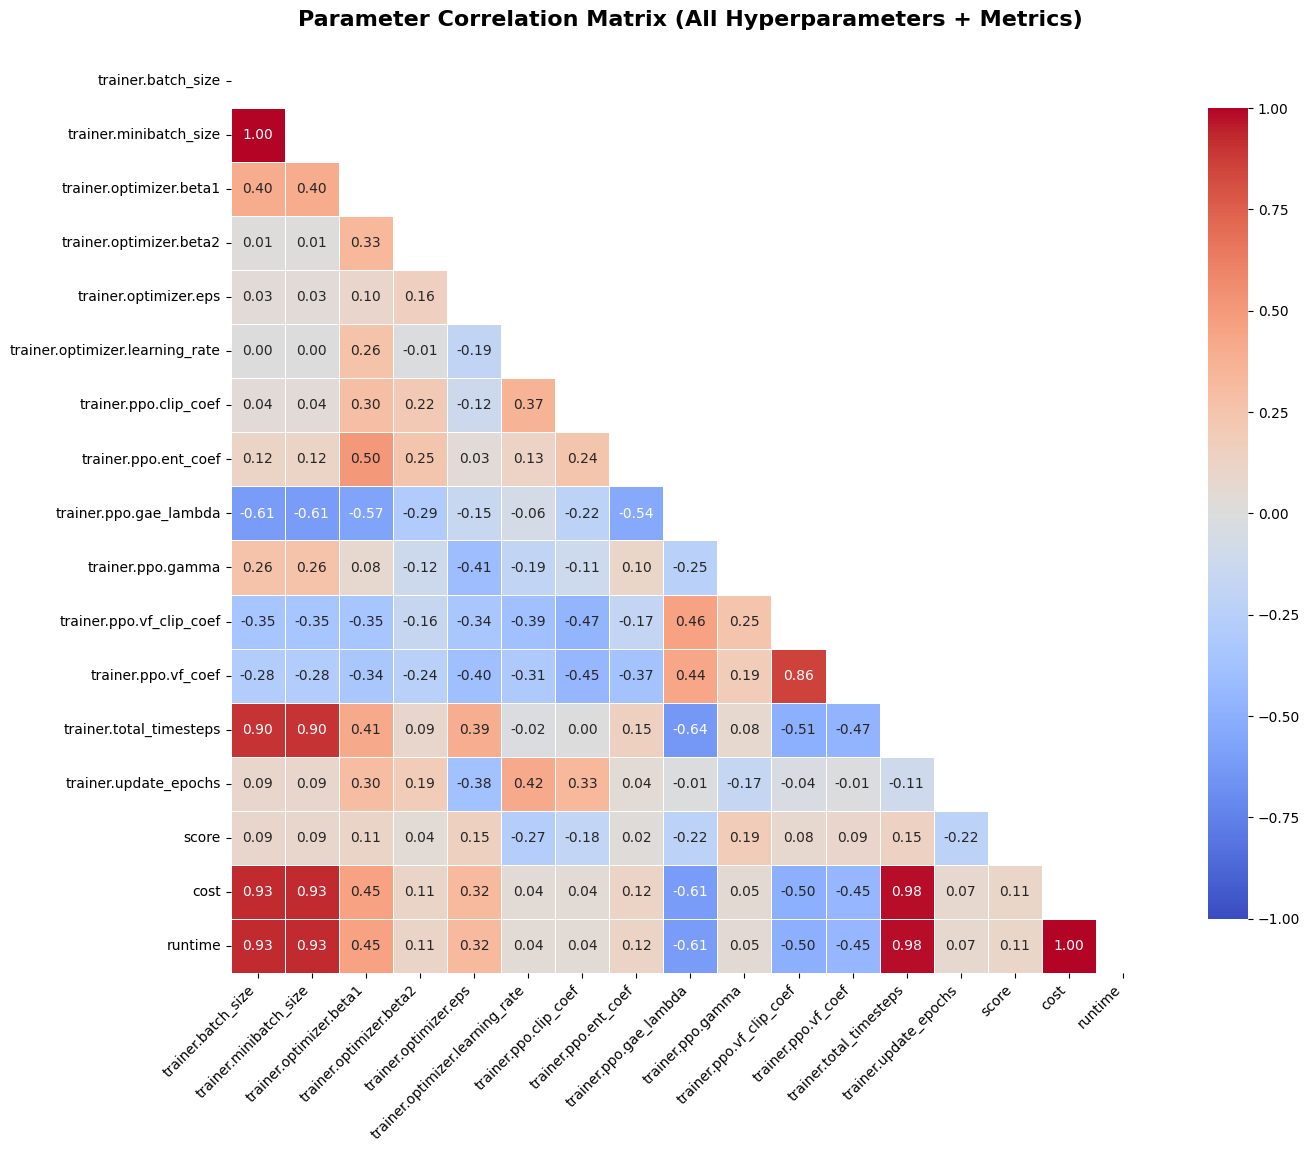

Correlation matrix includes 17 parameters
Showing top 17 most relevant parameters

Top 5 parameters most correlated with score:
  trainer.optimizer.learning_rate: 0.266
  trainer.ppo.gae_lambda: 0.221
  trainer.update_epochs: 0.220
  trainer.ppo.gamma: 0.193
  trainer.ppo.clip_coef: 0.182


In [96]:
if not df.empty:
    # The df already contains flattened observation data with all hyperparameters
    # Select only numeric columns (includes score, cost, runtime, and all hyperparameters)
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Remove columns with too few unique values (less than 2)
    valid_columns = []
    for col in numeric_df.columns:
        if numeric_df[col].nunique() >= 2:
            valid_columns.append(col)
    
    if len(valid_columns) > 1:
        # Calculate correlation matrix for all valid columns
        corr_matrix = numeric_df[valid_columns].corr()
        
        # If we have too many parameters, focus on those most correlated with score
        if 'score' in corr_matrix.columns and len(corr_matrix) > 20:
            # Always include score, cost, and runtime if they exist
            essential_cols = ['score', 'cost', 'runtime']
            essential_cols = [col for col in essential_cols if col in corr_matrix.columns]
            
            # Get top correlated parameters with score (excluding the essential columns)
            score_corr = corr_matrix['score'].abs().sort_values(ascending=False)
            # Remove essential columns from the correlation list to avoid duplicates
            score_corr = score_corr.drop(essential_cols, errors='ignore')
            
            # Take top parameters plus essential columns
            top_params = essential_cols + score_corr.head(20 - len(essential_cols)).index.tolist()
            corr_matrix = corr_matrix.loc[top_params, top_params]
        
        # Create heatmap
        plt.figure(figsize=(14, 12))
        
        # Create mask for upper triangle (optional - remove if you want full matrix)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Draw heatmap
        sns.heatmap(corr_matrix, 
                   mask=mask,
                   annot=True, 
                   fmt='.2f', 
                   cmap='coolwarm',
                   vmin=-1, 
                   vmax=1, 
                   center=0,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": 0.8})
        
        plt.title('Parameter Correlation Matrix (All Hyperparameters + Metrics)', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Correlation matrix includes {len(valid_columns)} parameters")
        print(f"Showing top {len(corr_matrix)} most relevant parameters")
        if 'score' in corr_matrix.columns:
            score_correlations = corr_matrix['score'].abs().sort_values(ascending=False)[1:6]  # Top 5 excluding self
            print("\nTop 5 parameters most correlated with score:")
            for param, corr in score_correlations.items():
                print(f"  {param}: {corr:.3f}")
    else:
        print("Not enough numeric parameters for correlation analysis")
else:
    print("No data available for correlation analysis")

## 6. Parameter Importance Analysis


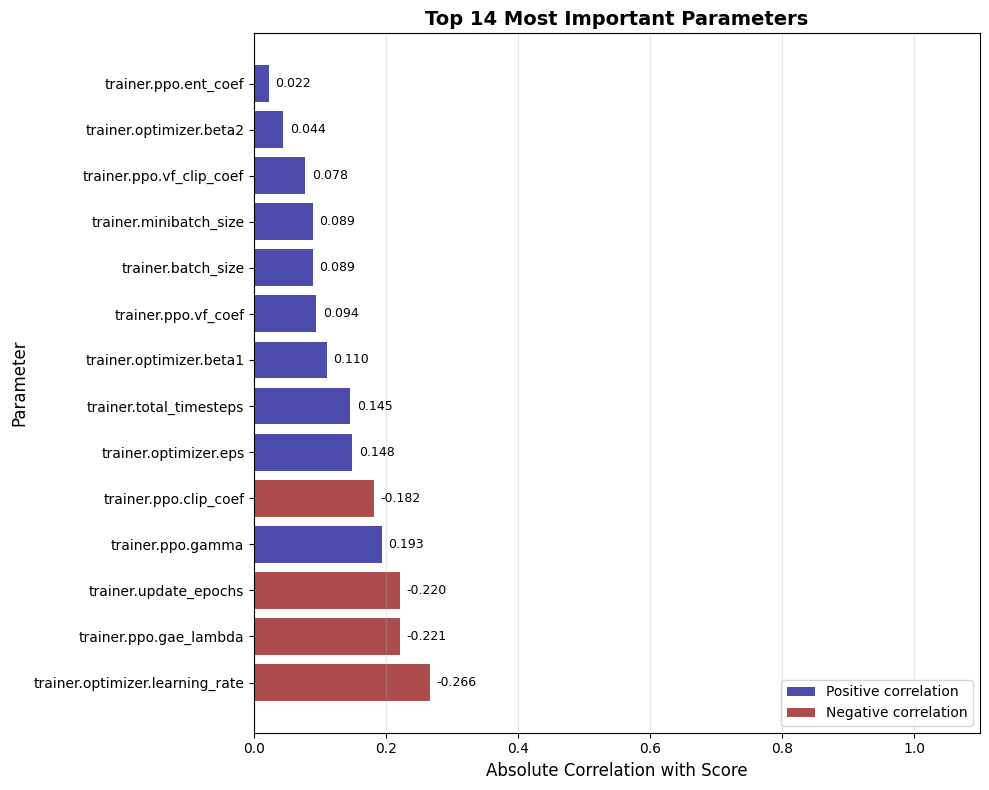


Parameter Importance Details:
trainer.optimizer.learning_rate ↓ -0.2663
trainer.ppo.gae_lambda         ↓ -0.2206
trainer.update_epochs          ↓ -0.2203
trainer.ppo.gamma              ↑ +0.1932
trainer.ppo.clip_coef          ↓ -0.1817
trainer.optimizer.eps          ↑ +0.1485
trainer.total_timesteps        ↑ +0.1454
trainer.optimizer.beta1        ↑ +0.1104
trainer.ppo.vf_coef            ↑ +0.0938
trainer.batch_size             ↑ +0.0890
trainer.minibatch_size         ↑ +0.0890
trainer.ppo.vf_clip_coef       ↑ +0.0778
trainer.optimizer.beta2        ↑ +0.0440
trainer.ppo.ent_coef           ↑ +0.0221


In [97]:
if not df.empty and 'score' in df.columns:
    # Select numeric columns excluding metrics
    metric_cols = ['score', 'cost', 'runtime', 'timestamp']
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    param_cols = [col for col in numeric_cols if col not in metric_cols]
    
    if len(param_cols) > 0:
        # Calculate correlations with score
        correlations = {}
        for col in param_cols:
            # Only include if we have enough unique values
            if df[col].nunique() >= 2:
                corr = df[col].corr(df['score'])
                if not np.isnan(corr):
                    correlations[col] = corr
        
        if correlations:
            # Sort by absolute correlation
            importance_df = pd.DataFrame([
                {'parameter': k, 'correlation': v, 'abs_correlation': abs(v)}
                for k, v in correlations.items()
            ]).sort_values('abs_correlation', ascending=False).head(TOP_K_PARAMETERS)
            
            # Create importance plot
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Create color map based on correlation direction
            colors = ['darkred' if x < 0 else 'darkblue' for x in importance_df['correlation']]
            
            # Create horizontal bar plot
            bars = ax.barh(importance_df['parameter'], 
                          importance_df['abs_correlation'],
                          color=colors, alpha=0.7)
            
            # Add correlation values as text
            for i, (idx, row) in enumerate(importance_df.iterrows()):
                ax.text(row['abs_correlation'] + 0.01, i, 
                       f"{row['correlation']:.3f}",
                       va='center', fontsize=9)
            
            ax.set_xlabel('Absolute Correlation with Score', fontsize=12)
            ax.set_ylabel('Parameter', fontsize=12)
            ax.set_title(f'Top {len(importance_df)} Most Important Parameters', 
                        fontsize=14, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.grid(True, axis='x', alpha=0.3)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='darkblue', alpha=0.7, label='Positive correlation'),
                Patch(facecolor='darkred', alpha=0.7, label='Negative correlation')
            ]
            ax.legend(handles=legend_elements, loc='lower right')
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed importance table
            print("\nParameter Importance Details:")
            print("=" * 60)
            for idx, row in importance_df.iterrows():
                direction = "↑" if row['correlation'] > 0 else "↓"
                print(f"{row['parameter']:30s} {direction} {row['correlation']:+.4f}")
        else:
            print("No valid parameter correlations found")
    else:
        print("No numeric parameters found for importance analysis")
else:
    print("No score data available for importance analysis")


## 8. Comprehensive Dashboard - All Plots in One Panel

This section aggregates all the key visualizations into a single comprehensive dashboard for easy overview of the sweep analysis.


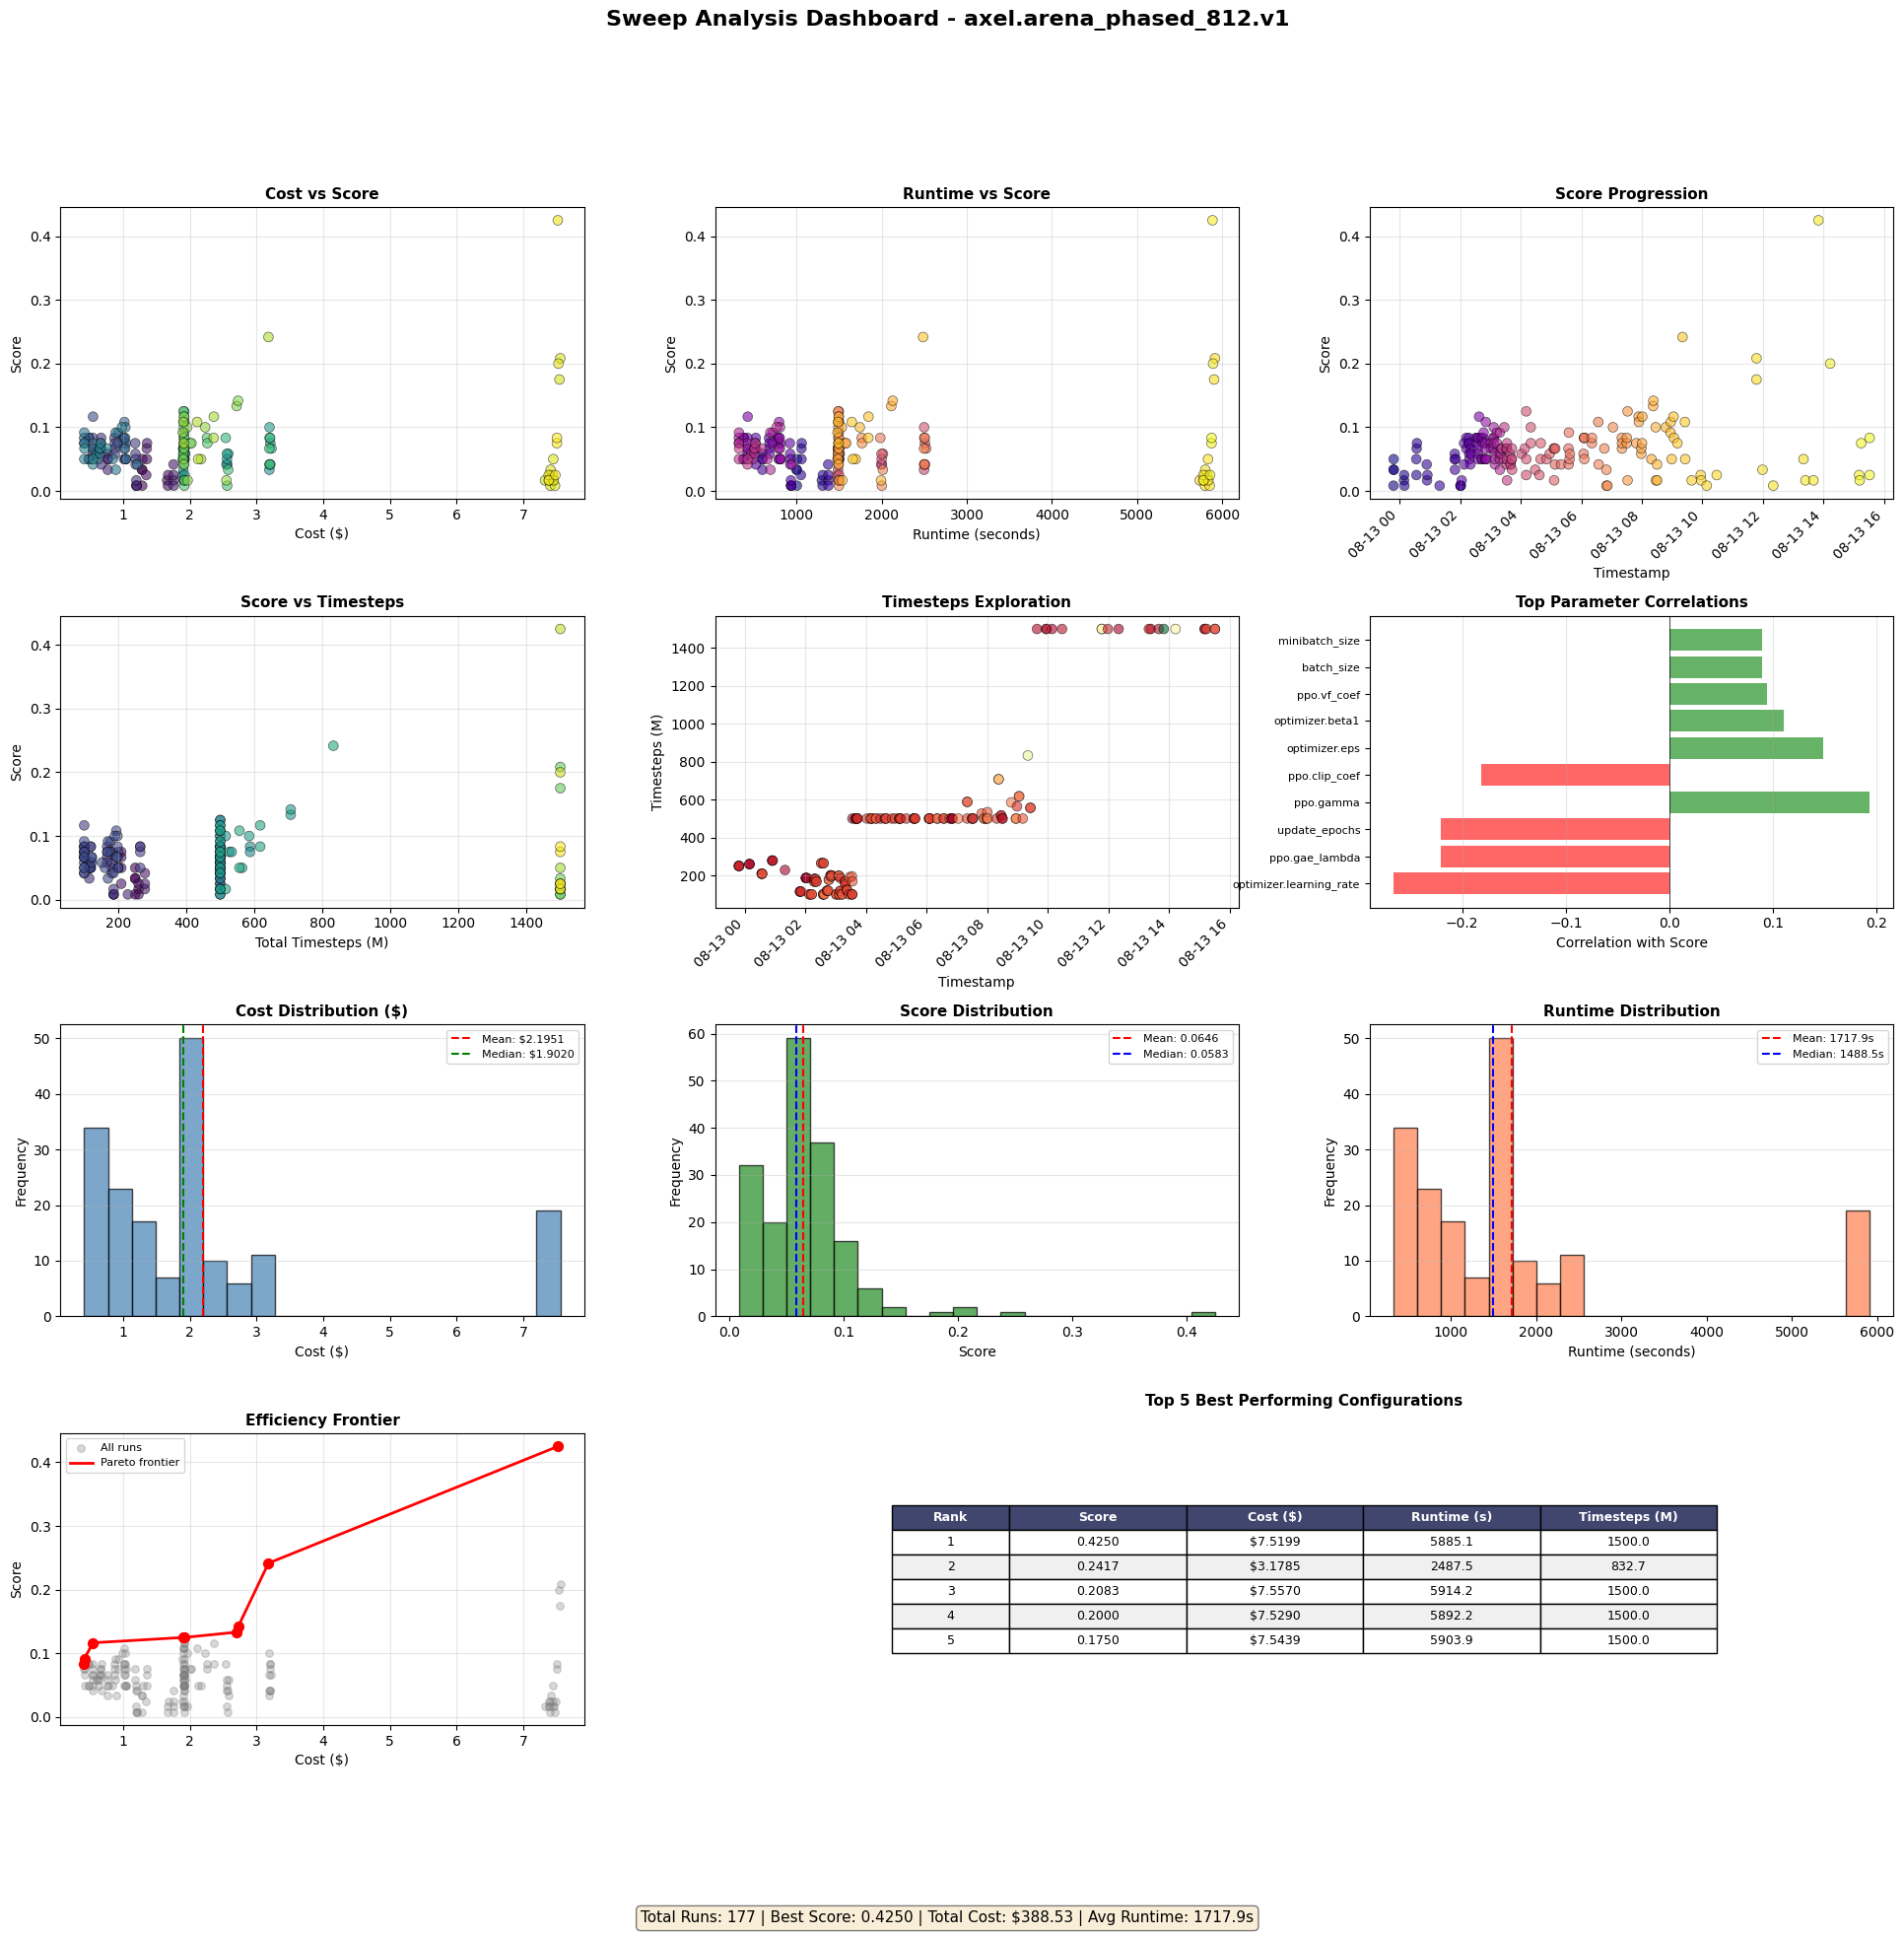

In [98]:
# Comprehensive Dashboard - All Plots in One Panel

if not df.empty:
    # Calculate dollar cost from runtime if not already present or if cost is actually runtime
    # Assuming $4.6/hour instance cost
    HOURLY_COST = 4.6
    if 'runtime' in df.columns:
        # Convert runtime (seconds) to dollar cost
        df['dollar_cost'] = (df['runtime'] / 3600.0) * HOURLY_COST
    
    # Use dollar_cost for all cost visualizations
    cost_col = 'dollar_cost' if 'dollar_cost' in df.columns else 'cost'
    
    # Create a large figure with subplots
    fig = plt.figure(figsize=(24, 20))
    
    # Define grid layout - 4 rows, 3 columns with more vertical spacing
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.25)
    
    # ========== Row 1 ==========
    # 1. Cost vs Score Scatter (with level sets)
    ax1 = fig.add_subplot(gs[0, 0])
    if cost_col in df.columns and 'score' in df.columns:
        plot_df = df[[cost_col, 'score']].dropna()
        if len(plot_df) > 0:
            scatter = ax1.scatter(plot_df[cost_col], plot_df['score'], 
                                alpha=0.6, s=50, c=range(len(plot_df)), 
                                cmap='viridis', edgecolors='black', linewidth=0.5)
            ax1.set_xlabel('Cost ($)', fontsize=10)
            ax1.set_ylabel('Score', fontsize=10)
            ax1.set_title('Cost vs Score', fontsize=11, fontweight='bold')
            ax1.grid(True, alpha=0.3)
    
    # 2. Time vs Score
    ax2 = fig.add_subplot(gs[0, 1])
    if 'runtime' in df.columns and 'score' in df.columns:
        plot_df = df[['runtime', 'score']].dropna()
        if len(plot_df) > 0:
            scatter = ax2.scatter(plot_df['runtime'], plot_df['score'],
                                alpha=0.6, s=50, c=range(len(plot_df)),
                                cmap='plasma', edgecolors='black', linewidth=0.5)
            ax2.set_xlabel('Runtime (seconds)', fontsize=10)
            ax2.set_ylabel('Score', fontsize=10)
            ax2.set_title('Runtime vs Score', fontsize=11, fontweight='bold')
            ax2.grid(True, alpha=0.3)
    
    # 3. Score Progression Over Time
    ax3 = fig.add_subplot(gs[0, 2])
    if 'timestamp' in df.columns and 'score' in df.columns:
        plot_df = df[['timestamp', 'score']].dropna()
        if len(plot_df) > 0:
            timestamps = pd.to_datetime(plot_df['timestamp'])
            scatter = ax3.scatter(timestamps, plot_df['score'], 
                               alpha=0.6, s=50, c=range(len(plot_df)), 
                               cmap='plasma', edgecolors='black', linewidth=0.5)
            ax3.set_xlabel('Timestamp', fontsize=10)
            ax3.set_ylabel('Score', fontsize=10)
            ax3.set_title('Score Progression', fontsize=11, fontweight='bold')
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # ========== Row 2 ==========
    # 4. Score vs Total Timesteps (with recency)
    ax4 = fig.add_subplot(gs[1, 0])
    if 'trainer.total_timesteps' in df.columns and 'score' in df.columns:
        plot_df = df[['trainer.total_timesteps', 'score', 'timestamp']].dropna()
        if len(plot_df) > 0:
            # Calculate recency
            if 'timestamp' in plot_df.columns:
                timestamps = pd.to_datetime(plot_df['timestamp'])
                min_time, max_time = timestamps.min(), timestamps.max()
                recency = (timestamps - min_time) / (max_time - min_time) if max_time > min_time else np.ones(len(plot_df))
            else:
                recency = np.linspace(0, 1, len(plot_df))
            
            scatter = ax4.scatter(plot_df['trainer.total_timesteps'] / 1e6, plot_df['score'],
                                c=recency, cmap='viridis', s=50, alpha=0.6,
                                edgecolors='black', linewidth=0.5)
            ax4.set_xlabel('Total Timesteps (M)', fontsize=10)
            ax4.set_ylabel('Score', fontsize=10)
            ax4.set_title('Score vs Timesteps', fontsize=11, fontweight='bold')
            ax4.grid(True, alpha=0.3)
            if plot_df['trainer.total_timesteps'].max() / plot_df['trainer.total_timesteps'].min() > 100:
                ax4.set_xscale('log')
    
    # 5. Timestamp vs Total Timesteps
    ax5 = fig.add_subplot(gs[1, 1])
    if 'trainer.total_timesteps' in df.columns and 'timestamp' in df.columns:
        plot_df = df[['timestamp', 'trainer.total_timesteps', 'score']].dropna()
        if len(plot_df) > 0:
            timestamps = pd.to_datetime(plot_df['timestamp'])
            timesteps_millions = plot_df['trainer.total_timesteps'] / 1e6
            scatter = ax5.scatter(timestamps, timesteps_millions,
                                c=plot_df['score'], cmap='RdYlGn', s=50, alpha=0.6,
                                edgecolors='black', linewidth=0.5)
            ax5.set_xlabel('Timestamp', fontsize=10)
            ax5.set_ylabel('Timesteps (M)', fontsize=10)
            ax5.set_title('Timesteps Exploration', fontsize=11, fontweight='bold')
            ax5.grid(True, alpha=0.3)
            plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
            if timesteps_millions.max() / timesteps_millions.min() > 100:
                ax5.set_yscale('log')
    
    # 6. Parameter Correlation Matrix (top parameters)
    ax6 = fig.add_subplot(gs[1, 2])
    param_cols = [col for col in df.columns if col.startswith('trainer.') and 
                  col not in ['trainer.total_timesteps'] and pd.api.types.is_numeric_dtype(df[col])]
    if param_cols and 'score' in df.columns:
        # Calculate correlations with score
        correlations = {}
        for col in param_cols:
            if df[col].notna().sum() > 10:
                corr = df[col].corr(df['score'])
                if not np.isnan(corr):
                    correlations[col] = corr
        
        # Get top 10 most correlated parameters
        if correlations:
            top_params = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
            if top_params:
                params, corrs = zip(*top_params)
                colors = ['green' if c > 0 else 'red' for c in corrs]
                bars = ax6.barh(range(len(params)), corrs, color=colors, alpha=0.6)
                ax6.set_yticks(range(len(params)))
                ax6.set_yticklabels([p.replace('trainer.', '') for p in params], fontsize=8)
                ax6.set_xlabel('Correlation with Score', fontsize=10)
                ax6.set_title('Top Parameter Correlations', fontsize=11, fontweight='bold')
                ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
                ax6.grid(True, alpha=0.3, axis='x')
    
    # ========== Row 3 ==========
    # 7. Cost Distribution
    ax7 = fig.add_subplot(gs[2, 0])
    if cost_col in df.columns:
        cost_data = df[cost_col].dropna()
        if len(cost_data) > 0:
            ax7.hist(cost_data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax7.axvline(cost_data.mean(), color='red', linestyle='--', label=f'Mean: ${cost_data.mean():.4f}')
            ax7.axvline(cost_data.median(), color='green', linestyle='--', label=f'Median: ${cost_data.median():.4f}')
            ax7.set_xlabel('Cost ($)', fontsize=10)
            ax7.set_ylabel('Frequency', fontsize=10)
            ax7.set_title('Cost Distribution ($)', fontsize=11, fontweight='bold')
            ax7.legend(fontsize=8)
            ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Score Distribution
    ax8 = fig.add_subplot(gs[2, 1])
    if 'score' in df.columns:
        score_data = df['score'].dropna()
        if len(score_data) > 0:
            ax8.hist(score_data, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
            ax8.axvline(score_data.mean(), color='red', linestyle='--', label=f'Mean: {score_data.mean():.4f}')
            ax8.axvline(score_data.median(), color='blue', linestyle='--', label=f'Median: {score_data.median():.4f}')
            ax8.set_xlabel('Score', fontsize=10)
            ax8.set_ylabel('Frequency', fontsize=10)
            ax8.set_title('Score Distribution', fontsize=11, fontweight='bold')
            ax8.legend(fontsize=8)
            ax8.grid(True, alpha=0.3, axis='y')
    
    # 9. Runtime Distribution
    ax9 = fig.add_subplot(gs[2, 2])
    if 'runtime' in df.columns:
        runtime_data = df['runtime'].dropna()
        if len(runtime_data) > 0:
            ax9.hist(runtime_data, bins=20, alpha=0.7, color='coral', edgecolor='black')
            ax9.axvline(runtime_data.mean(), color='red', linestyle='--', label=f'Mean: {runtime_data.mean():.1f}s')
            ax9.axvline(runtime_data.median(), color='blue', linestyle='--', label=f'Median: {runtime_data.median():.1f}s')
            ax9.set_xlabel('Runtime (seconds)', fontsize=10)
            ax9.set_ylabel('Frequency', fontsize=10)
            ax9.set_title('Runtime Distribution', fontsize=11, fontweight='bold')
            ax9.legend(fontsize=8)
            ax9.grid(True, alpha=0.3, axis='y')
    
    # ========== Row 4 ==========
    # 10. Efficiency Frontier (Pareto)
    ax10 = fig.add_subplot(gs[3, 0])
    if cost_col in df.columns and 'score' in df.columns:
        plot_df = df[[cost_col, 'score']].dropna()
        if len(plot_df) > 0:
            # Find Pareto frontier
            sorted_df = plot_df.sort_values(cost_col)
            pareto_front = []
            max_score = -np.inf
            for _, row in sorted_df.iterrows():
                if row['score'] >= max_score:
                    pareto_front.append(row)
                    max_score = row['score']
            
            if pareto_front:
                pareto_df = pd.DataFrame(pareto_front)
                ax10.scatter(plot_df[cost_col], plot_df['score'], alpha=0.3, s=30, color='gray', label='All runs')
                ax10.plot(pareto_df[cost_col], pareto_df['score'], 'r-', linewidth=2, label='Pareto frontier')
                ax10.scatter(pareto_df[cost_col], pareto_df['score'], color='red', s=50, zorder=5)
                ax10.set_xlabel('Cost ($)', fontsize=10)
                ax10.set_ylabel('Score', fontsize=10)
                ax10.set_title('Efficiency Frontier', fontsize=11, fontweight='bold')
                ax10.legend(fontsize=8)
                ax10.grid(True, alpha=0.3)
    
    # 11. Top 5 Configurations Table (as text plot)
    ax11 = fig.add_subplot(gs[3, 1:])
    ax11.axis('off')
    
    if 'score' in df.columns:
        top_5 = df.nlargest(5, 'score')
        
        # Create table data
        table_data = []
        headers = ['Rank', 'Score', 'Cost ($)', 'Runtime (s)', 'Timesteps (M)']
        
        for i, (idx, row) in enumerate(top_5.iterrows(), 1):
            # Calculate dollar cost for the table
            dollar_cost_val = row.get(cost_col, row.get('runtime', 0) * HOURLY_COST / 3600.0 if 'runtime' in row else 0)
            row_data = [
                f"{i}",
                f"{row.get('score', 'N/A'):.4f}" if pd.notna(row.get('score')) else 'N/A',
                f"${dollar_cost_val:.4f}" if pd.notna(dollar_cost_val) else 'N/A',
                f"{row.get('runtime', 0):.1f}" if pd.notna(row.get('runtime')) else 'N/A',
                f"{row.get('trainer.total_timesteps', 0)/1e6:.1f}" if pd.notna(row.get('trainer.total_timesteps')) else 'N/A'
            ]
            table_data.append(row_data)
        
        # Create table
        table = ax11.table(cellText=table_data, colLabels=headers,
                          cellLoc='center', loc='center',
                          colWidths=[0.1, 0.15, 0.15, 0.15, 0.15])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        # Style the table
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        for i in range(1, len(table_data) + 1):
            for j in range(len(headers)):
                table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        ax11.set_title('Top 5 Best Performing Configurations', fontsize=11, fontweight='bold', pad=20)
    
    # Add main title
    fig.suptitle(f'Sweep Analysis Dashboard - {WANDB_SWEEP_NAME}', fontsize=16, fontweight='bold', y=0.98)
    
    # Add summary statistics as text
    total_runs = len(df)
    best_score = df['score'].max() if 'score' in df.columns else 'N/A'
    total_cost = df[cost_col].sum() if cost_col in df.columns else 'N/A'
    avg_runtime = df['runtime'].mean() if 'runtime' in df.columns else 'N/A'
    
    if isinstance(best_score, (int, float)):
        best_score_str = f"{best_score:.4f}"
    else:
        best_score_str = str(best_score)
    
    if isinstance(total_cost, (int, float)):
        total_cost_str = f"${total_cost:.2f}"
    else:
        total_cost_str = str(total_cost)
        
    if isinstance(avg_runtime, (int, float)):
        avg_runtime_str = f"{avg_runtime:.1f}s"
    else:
        avg_runtime_str = str(avg_runtime)
    
    summary_text = (f"Total Runs: {total_runs} | "
                   f"Best Score: {best_score_str} | "
                   f"Total Cost: {total_cost_str} | "
                   f"Avg Runtime: {avg_runtime_str}")
    
    fig.text(0.5, 0.01, summary_text, ha='center', fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data available to create dashboard")


## 7. Additional Analysis - Best Configurations


In [99]:
# Show top performing configurations
if not df.empty and 'score' in df.columns:
    # Get top 5 configurations
    top_configs = df.nlargest(5, 'score')
    
    print("\nTop 5 Best Performing Configurations:")
    print("=" * 80)
    
    for i, (idx, row) in enumerate(top_configs.iterrows(), 1):
        print(f"\nRank {i}: Score = {row['score']:.4f}, Runtime = {row.get('runtime', 'N/A')}s")
        if 'timestamp' in row and pd.notna(row['timestamp']):
            print(f"         Created at: {row['timestamp']}")
        print("-" * 40)
        
        # Show only parameters that differ from the median
        param_cols = [col for col in df.columns if col not in ['score', 'cost', 'runtime', 'timestamp']]
        for col in param_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                if abs(row[col] - median_val) > 0.01 * abs(median_val):  # More than 1% different
                    print(f"  {col}: {row[col]:.4f} (median: {median_val:.4f})")



Top 5 Best Performing Configurations:

Rank 1: Score = 0.4250, Runtime = 5885.119097709656s
         Created at: 2025-08-13 13:49:42+00:00
----------------------------------------
  trainer.batch_size: 262144.0000 (median: 131072.0000)
  trainer.minibatch_size: 8192.0000 (median: 4096.0000)
  trainer.optimizer.beta1: 0.9300 (median: 0.8990)
  trainer.optimizer.eps: 0.0000 (median: 0.0000)
  trainer.optimizer.learning_rate: 0.0001 (median: 0.0001)
  trainer.ppo.clip_coef: 0.1000 (median: 0.0945)
  trainer.ppo.ent_coef: 0.0017 (median: 0.0008)
  trainer.ppo.gae_lambda: 0.9111 (median: 0.9782)
  trainer.ppo.vf_clip_coef: 25.0000 (median: 30.0000)
  trainer.ppo.vf_coef: 0.7500 (median: 0.8000)
  trainer.total_timesteps: 1500000000.0000 (median: 500000000.0000)
  dollar_cost: 7.5199 (median: 1.9020)

Rank 2: Score = 0.2417, Runtime = 2487.502774000168s
         Created at: 2025-08-13 09:20:28+00:00
----------------------------------------
  trainer.optimizer.beta1: 0.9464 (median: 0.8990)


## 9. Evaluation Method Verification

This section tests different evaluation methods to verify we're calculating scores correctly and using the right checkpoints.


## 9. Evaluation Method Verification

This section tests different evaluation methods to verify we're calculating scores correctly and using the right checkpoints.


In [100]:
print(df)
# save to csv
df.to_csv("sweep_analysis.csv", index=False)

     trainer.batch_size  trainer.bptt_horizon  trainer.minibatch_size  \
0                131072                    16                    4096   
1                131072                    16                    4096   
2                131072                    16                    4096   
3                131072                    16                    4096   
4                131072                    16                    4096   
..                  ...                   ...                     ...   
172              262144                    16                    8192   
173              262144                    16                    8192   
174              262144                    16                    8192   
175              262144                    16                    8192   
176              262144                    16                    8192   

     trainer.optimizer.beta1  trainer.optimizer.beta2  trainer.optimizer.eps  \
0                   0.900000               